# Workshop 1

- Mateo Gonzalez Ocampo CC 1037639531
- Juan Alejandro Uribe Ramirez CC 1037627601 

## 1. Intalación FastAI

In [3]:
!pip install fastai==1.0.61

## 2. Importar FastAI

In [4]:
from fastai.vision import *
from fastai.vision import DatasetFo
from pathlib import Path

## 3. Descargar imagenes usando codigo de Javascript proporcionado

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Se descargaron 3 csv con los links para las diferentes clases:
- skirt.csv
- shirt.csv
- pants.csv

Los archivos se encuentran en el mismo directorio que este notebook.

## 4. Creación de directorios para cada clase

In [5]:
import shutil

def create_dir_and_download_images(path: str, base_dir: Path):
    folder = path
    file = f"{folder}.csv"
    print(folder)
    print(file)
    
    print("-----------------------------------------")
    dest = base_dir/folder
    dest.mkdir(parents=True, exist_ok=True)
    print(dest)
    print(base_dir)
    
    if not (dest/file).exists():
        shutil.copy(file, dest/file)
    print(f"Descargando imagenes tomadas de {dest/file}")
    download_images(dest/file, dest, max_pics=100)

base_dir = './clases'
path = Path(base_dir)
classes = ['skirt', 'shirt', 'pants']

for cl in classes:
    create_dir_and_download_images(cl, path)

skirt
skirt.csv
-----------------------------------------
clases/skirt
clases
Descargando imagenes tomadas de clases/skirt/skirt.csv


shirt
shirt.csv
-----------------------------------------
clases/shirt
clases
Descargando imagenes tomadas de clases/shirt/shirt.csv


pants
pants.csv
-----------------------------------------
clases/pants
clases
Descargando imagenes tomadas de clases/pants/pants.csv


## 5. Crear carpeta de test con dos imagenes para cada clase

In [6]:
test_dir = "./test"
test_path = Path(test_dir)
test_path.ls()

[PosixPath('test/pants2.png'),
 PosixPath('test/shirt2.jpg'),
 PosixPath('test/pants1.jpg'),
 PosixPath('test/skirt2.jpg'),
 PosixPath('test/shirt1.png'),
 PosixPath('test/skirt1.jpg')]

## 7 y 8. Creación del objeto *data*, que contiene las clases y los datos de entrenamiento con un 20% para el tamaño del conjunto de validación

In [7]:
np.random.seed(42)

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

data.classes

['pants', 'shirt', 'skirt']

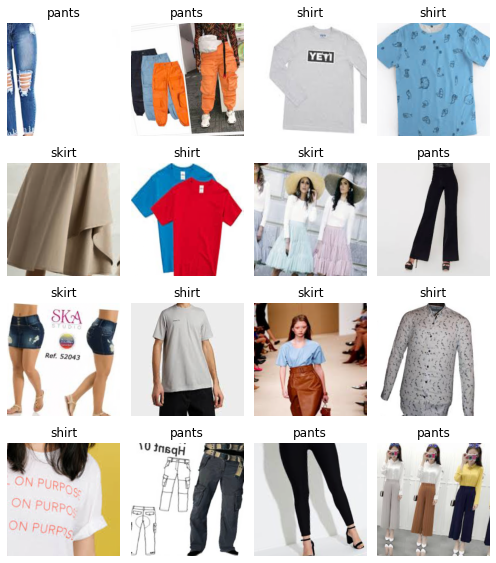

In [8]:
data.show_batch(rows=4, figsize=(7, 8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['pants', 'shirt', 'skirt'], 3, 480, 120)

## 9. Entrenar modelo con ResNet34 y tamaño de chip 224 x 224 (Definido en el punto anterior)

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.411896,0.881929,0.266667,00:07
1,0.937523,0.565290,0.141667,00:04
2,0.708610,0.542777,0.125000,00:04
3,0.583513,0.566907,0.150000,00:05
4,0.495879,0.564487,0.141667,00:05


### 10. Encontrar y graficar el learning rate (LR)

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


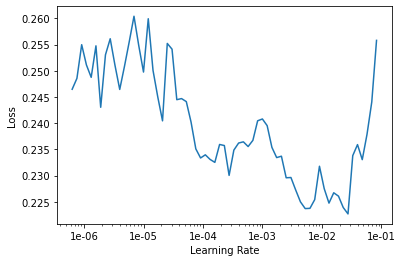

In [13]:
learn.recorder.plot()

## 11. Desbloquear modelo y reentrenar con un LR diferencial, pues las primeras capas necesitan menos tuning

In [14]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-7, 2e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.289262,0.600573,0.166667,00:07
1,0.437048,0.895042,0.158333,00:06
2,0.445346,0.602940,0.125000,00:06
3,0.401062,0.528182,0.108333,00:06
4,0.333004,0.483391,0.100000,00:06


In [22]:
learn.save('model1')

## 12. Matriz de confusión y top losses

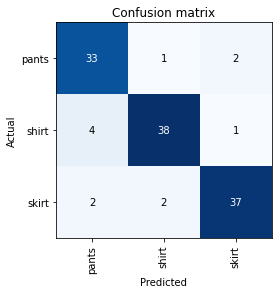

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

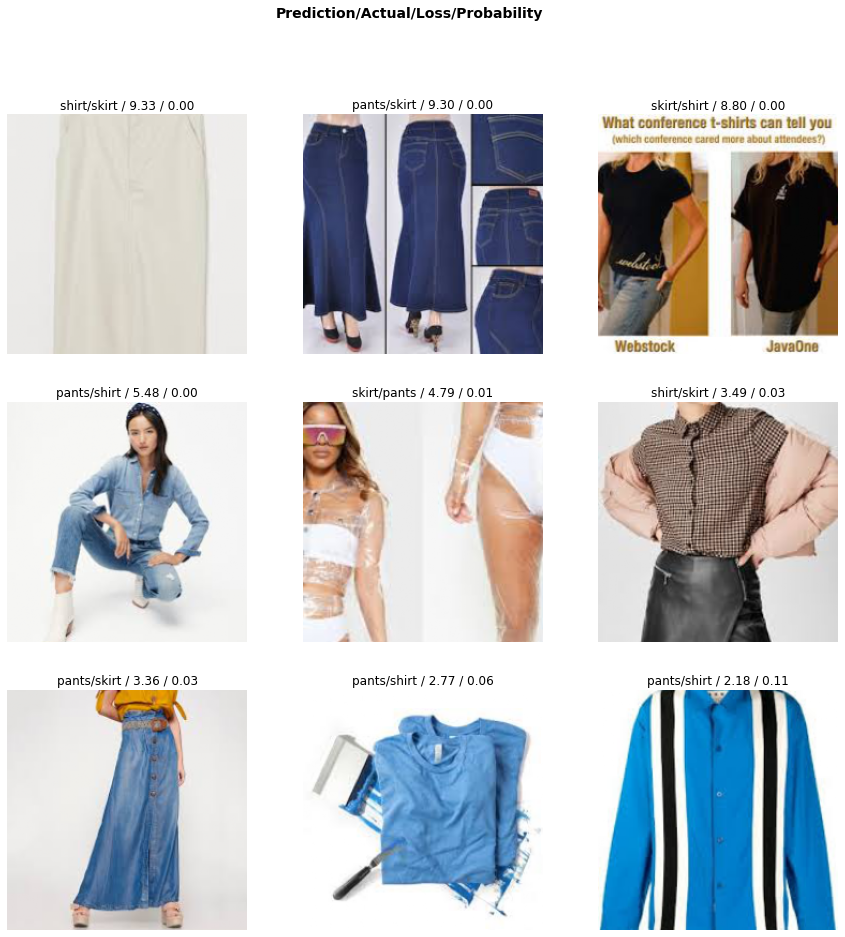

In [16]:
interp.plot_top_losses(9, figsize=(15,15))

### Limpieza de imagenes

In [19]:
db = (ImageList.from_folder(path)
               .split_none()
               .label_from_folder()
               .transform(get_transforms(), size=224)
               .databunch())

In [24]:
from fastai.widgets import *

learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('model1');

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [25]:
#ImageCleaner(ds, idxs, path)

'No images to show :)'

### Entrenemos con los datos limpios

In [27]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [28]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.724296,0.608377,0.213483,00:04
1,1.085508,0.210899,0.067416,00:03
2,0.808505,0.182407,0.067416,00:03
3,0.629238,0.147118,0.056180,00:03
4,0.528499,0.143182,0.044944,00:03


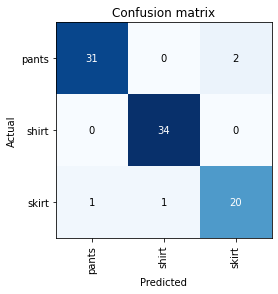

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

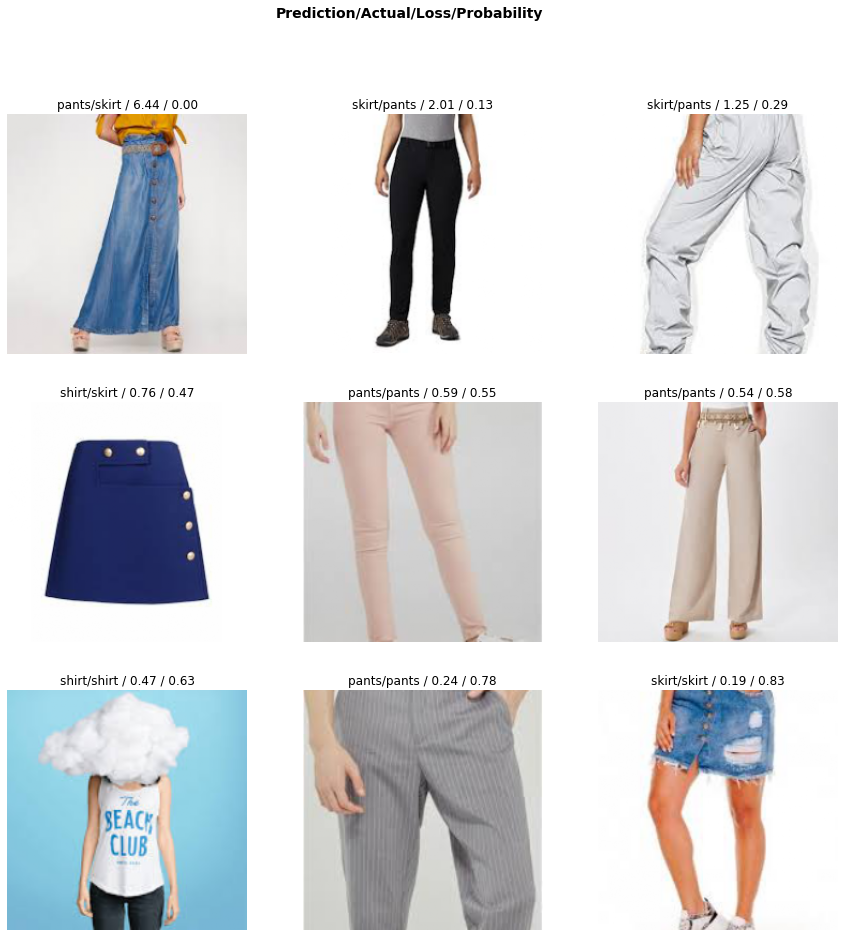

In [31]:
interp.plot_top_losses(9, figsize=(15,15))

## 13. Guardar parametros y exportar modelo

In [32]:
learn.save('model1')
learn.export()

## 14. Realizar predicciones sobre imagenes de prueba

/home/mateo/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/mateo/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  w

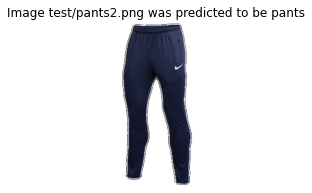

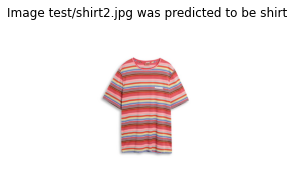

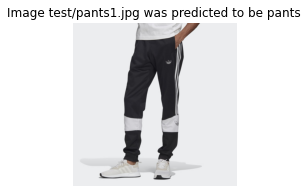

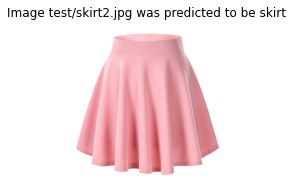

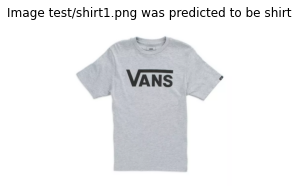

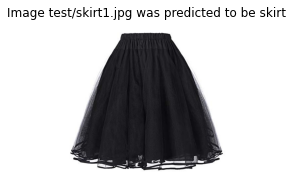

In [33]:
for p in test_path.ls():
    img = open_image(p)
    pred_class, pred_idx, outputs = learn.predict(img)
    ax = show_image(img)
    ax.set_title(f"Image {p} was predicted to be {pred_class}")

## Plus: Entrenar modelo con tamaño de chip 128 x 128 y comparar con el modelo previamente entrenado

In [34]:
data_128 = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=128, num_workers=4).normalize(imagenet_stats)

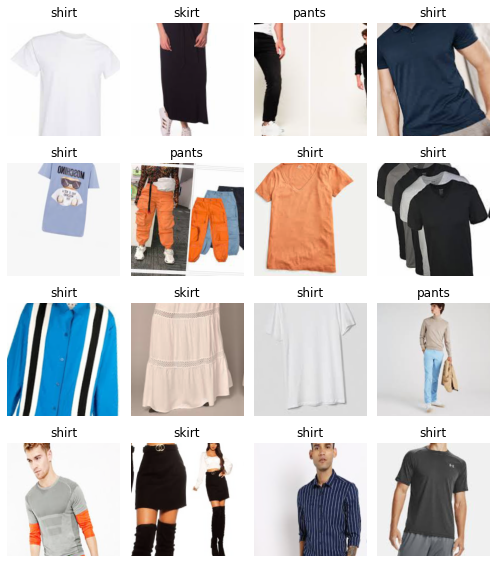

In [35]:
data.show_batch(rows=4, figsize=(7, 8))

In [36]:
learn_128 = cnn_learner(data_128, models.resnet34, metrics=error_rate)

In [38]:
learn_128.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.821878,1.193011,0.426966,00:02
1,1.236941,0.405001,0.146067,00:01
2,0.977952,0.439753,0.146067,00:01
3,0.824042,0.483072,0.146067,00:01
4,0.709141,0.518570,0.134831,00:01


El modelo con imagenes de 128 x 128 presenta un *error_rate* mayor al modelo original, esto se debe a que al tener mayor cantidad de pixeles, los modelos pueden aprender caracteristicas mas complejas, pues existe mayor cantidad de informacion contenida en una sola image.

## Bonus plus: Entrenar modelo con transformaciones sobre las imagenes y comparar con el modelo previamente entrenado

In [45]:
transform = get_transforms(do_flip=True, max_rotate=15, max_zoom=1.3, max_lighting=0.4)
data_transform = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=transform, size=128, num_workers=4).normalize(imagenet_stats)

In [46]:
learn_transform = cnn_learner(data_128, models.resnet34, metrics=error_rate)

In [47]:
learn_transform.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.719875,1.099888,0.415730,00:01
1,1.268044,0.266947,0.112360,00:01
2,0.980456,0.327548,0.101124,00:01
3,0.814020,0.403227,0.112360,00:01
4,0.698153,0.425314,0.123596,00:01


El model con las transformaciones tiene un error_rate mayor al modelo original, y presenta un valor de perdida mayor en el conjunto de validación, lo que podría ser indicio de overfitting en este modelo.

### Bonus plus plus: Servicio web para realizar predicciones

Url del servicio: https://workshop1-unal.herokuapp.com/?url=<URL> donde <URL> es la dirección de la imagen que se desea clasificar.